# Introduction to Apache Spark Resilient Distributed Datasets (RDD)

### Initialization ###
Starting Spark session:

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar -xvf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

spark-3.1.2-bin-hadoop3.2/
spark-3.1.2-bin-hadoop3.2/R/
spark-3.1.2-bin-hadoop3.2/R/lib/
spark-3.1.2-bin-hadoop3.2/R/lib/sparkr.zip
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/worker.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/daemon.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/testthat/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/testthat/test_basic.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/shell.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/general.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.html
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.Rmd
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/index.html
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/R/
spark-3.1.2-

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [5]:
spark

In [6]:
sc = spark.sparkContext

### Reading text files

Download a file locally (just for the demo, for larger files use HDFS or S3):

In [7]:
import urllib.request

In [8]:
urllib.request.urlretrieve("http://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs","apache_logs")

('apache_logs', <http.client.HTTPMessage at 0x7b553c049630>)

Create a first RDD

In [9]:
# lines jest obiektem RDD, czyli jest utworzony na węzłach roboczych, wczytany do pamięci, podzielony
lines = sc.textFile("apache_logs")

Perform a *transformation*

In [11]:
# transformacja tworzy nowy obiekt RDD, jest tu zdefiniowana operacja w jaki sposób obiekt ma powstać. Utworzenie tego obiektu nie jest jeszcze wykonane, zostanie to zrobione dopiero jak wynik będzie potrzebny -> przetwarzanie leniwe
lineLengths = lines.map(lambda s: len(s))

Perform an *action*

In [12]:
# sumowanie wszyskich elementów
totalLength = lineLengths.reduce(lambda a, b: a + b)

Finally evaluate (laziness!)

In [13]:
totalLength

2360789

DAG -> wszystkie operacje spark są prezentowane w formie grafu DAG. Graf acykliczny, skierowany

### Custom functions

In [14]:
def myFunc(s):
    words = s.split(" ")
    return len(words)

In [15]:
wordCounts = lines.map(myFunc)

In [16]:
wordCounts.max()

43

In [17]:
wordCounts.histogram([0,10,20,30,40,50])

([0, 10, 20, 30, 40, 50], [0, 4901, 4719, 378, 2])

In [18]:
wordCounts.count()

10000

### Map-Reduce pattern

Let's look closer at our log file format:

```
99.158.0.150 - - [18/May/2015:04:05:37 +0000] "GET /images/jordan-80.png HTTP/1.1" 200 6146 "http://www.semicomplete.com/articles/dynamic-dns-with-dhcp/" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/32.0.1700.102 Chrome/32.0.1700.102 Safari/537.36"
```

Count lines containing "Chrome":

In [19]:
# wzorzec map reduce, tzn że najpierw aplikujemy funkcję do każdego elementu kolekcji rozproszonej RDD (za pomocą map), a potem wykonujemy redukcję np. sumowania / agregacji (za pomocą reduce)
chromeLines = lines.map(lambda s: (1 if "Chrome" in s else 0))

In [22]:
# sumujemy tą nową kolekcję zer i jedynek
counts = chromeLines.reduce(lambda a, b: a + b)

In [23]:
counts

3172

### Key-Value Pairs

Count IP addresses

In [24]:
regex = '([(\d\.)]+)'

In [25]:
import re

In [26]:
ip = re.match(regex, '99.158.0.150 - - ').group(0)

In [27]:
print(ip)

99.158.0.150


In [28]:
ips = lines.map(lambda s: (re.match(regex, s).group(0) ,1))

In [29]:
# liczba wystąpien adresu klienta
ipCounts = ips.reduceByKey(lambda a, b: a + b)

Get results

In [30]:
# collect pobiera wszystkie
ipCounts.collect()

[('83.149.9.216', 23),
 ('110.136.166.128', 6),
 ('46.105.14.53', 364),
 ('123.125.71.35', 1),
 ('200.49.190.100', 1),
 ('67.214.178.190', 2),
 ('207.241.237.220', 18),
 ('207.241.237.227', 17),
 ('207.241.237.228', 16),
 ('218.30.103.62', 16),
 ('71.212.224.97', 5),
 ('86.1.76.62', 6),
 ('107.170.41.69', 10),
 ('208.115.111.72', 83),
 ('174.37.205.76', 1),
 ('134.76.249.10', 8),
 ('123.125.71.117', 1),
 ('65.19.138.34', 3),
 ('5.102.173.71', 2),
 ('187.45.193.158', 8),
 ('36.38.8.174', 6),
 ('71.207.12.53', 2),
 ('220.241.45.142', 2),
 ('146.1.1.2', 15),
 ('178.255.215.83', 22),
 ('50.131.51.216', 17),
 ('212.197.170.45', 2),
 ('108.32.74.68', 14),
 ('180.76.5.27', 1),
 ('93.164.60.142', 1),
 ('108.178.4.100', 2),
 ('111.199.235.239', 37),
 ('108.171.116.194', 65),
 ('94.175.135.116', 1),
 ('207.241.237.104', 13),
 ('83.31.73.148', 2),
 ('180.76.6.156', 2),
 ('92.108.120.46', 2),
 ('172.56.29.98', 1),
 ('173.252.73.114', 1),
 ('217.69.133.70', 4),
 ('217.69.133.237', 4),
 ('209.17.114

In [31]:
# wybranie pierwszych 20
ipCounts.take(20)

[('83.149.9.216', 23),
 ('110.136.166.128', 6),
 ('46.105.14.53', 364),
 ('123.125.71.35', 1),
 ('200.49.190.100', 1),
 ('67.214.178.190', 2),
 ('207.241.237.220', 18),
 ('207.241.237.227', 17),
 ('207.241.237.228', 16),
 ('218.30.103.62', 16),
 ('71.212.224.97', 5),
 ('86.1.76.62', 6),
 ('107.170.41.69', 10),
 ('208.115.111.72', 83),
 ('174.37.205.76', 1),
 ('134.76.249.10', 8),
 ('123.125.71.117', 1),
 ('65.19.138.34', 3),
 ('5.102.173.71', 2),
 ('187.45.193.158', 8)]

Sort by values (ascending):

In [33]:
# sortuje po drugim elemencie z pary
ipCounts.takeOrdered(10, lambda pair: pair[1])

[('123.125.71.35', 1),
 ('200.49.190.100', 1),
 ('174.37.205.76', 1),
 ('123.125.71.117', 1),
 ('180.76.5.27', 1),
 ('93.164.60.142', 1),
 ('94.175.135.116', 1),
 ('172.56.29.98', 1),
 ('173.252.73.114', 1),
 ('54.226.176.99', 1)]

Sort by values (descending):

In [35]:
# sortowanie po drugim elemencie z pary w kolejności malejącej
# 10 najpopularniejszych adresów ip
topIPs = ipCounts.takeOrdered(10, lambda pair: -pair[1])
topIPs

[('66.249.73.135', 482),
 ('46.105.14.53', 364),
 ('130.237.218.86', 357),
 ('75.97.9.59', 273),
 ('50.16.19.13', 113),
 ('209.85.238.199', 102),
 ('68.180.224.225', 99),
 ('100.43.83.137', 84),
 ('208.115.111.72', 83),
 ('198.46.149.143', 82)]

### Plotting

In [36]:
import pandas as pd

In [37]:
df = pd.DataFrame(topIPs, columns=['IP', 'Count'])
df

,IP,Count
0,66.249.73.135,482
1,46.105.14.53,364
2,130.237.218.86,357
3,75.97.9.59,273
4,50.16.19.13,113
5,209.85.238.199,102
6,68.180.224.225,99
7,100.43.83.137,84
8,208.115.111.72,83
9,198.46.149.143,82


In [38]:
import matplotlib.pyplot as plt

<Axes: ylabel='IP'>

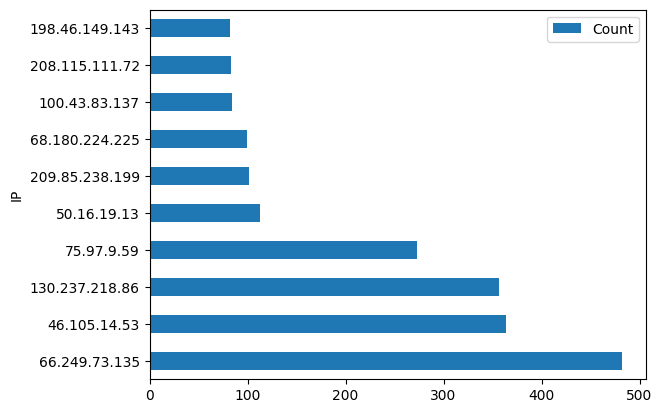

In [39]:
df.plot.barh(x = 'IP')

### Closures and accumulators

Kod sparka jest częściowo wykonywany w shellu sparka w jupyter, a część jest odpalana na węzłach roboczych.

Jeżeli stworzymy zmienną lokalną np. Counter i utworzymy funkcję która będzie zwiększać counter, to jeżeli odpalimy to na RDD, to funkcja zostanie przekazana do workera. Każdy z nich będzie operował na swoim liczniku.

Ponieważ to co jest uruchamiane na workerach nie może być przekazane do globalnego countera.

Local variables are not passed to closures or functions, they remain local!

In [40]:
counter = 0

# Wrong: Don't do this!!
def increment_counter(x):
    global counter
    counter += x

wordCounts.foreach(increment_counter)

print("Counter value: ", counter)

Counter value:  0


Use *accumulators* instead

In [41]:
accum = sc.accumulator(0)
accum

Accumulator<id=0, value=0>

In [42]:
# Correct way is to use accumulators
def increment_counter(x):
    accum.add(x)

wordCounts.foreach(increment_counter)

print("Counter value: ", accum)

Counter value:  197956


# Homework

### Task 1:

Narysować wykres rankingu najpopularniejszych stron źródłowych (referer), z wyłączeniem domeny semicomplete.com

In [131]:
regex_referer = r'"(https?://(?!(www\.)?semicomplete\.com).+?)"'

In [132]:
import re
referer_test = re.search(regex_referer, 'fdsfsf "http://semicomplete.com/presentations/logstash-monitorama-2013/" btret "http://dummy_domain.com/abc/" - gfdg').group(0)

print(referer_test)

"http://dummy_domain.com/abc/"


In [136]:
referer = lines.map(lambda s: (re.search(regex_referer, s).group(1) if re.search(regex_referer, s) else "Referer not found", 1))

In [137]:
refererCount = referer.reduceByKey(lambda a, b: a + b)

In [138]:
refererCount.collect()

[('http://www.google.ro/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&ved=0CCwQFjAB&url=http%3A%2F%2Fwww.semicomplete.com%2Farticles%2Fdynamic-dns-with-dhcp%2F&ei=W88AU4n9HOq60QXbv4GwBg&usg=AFQjCNEF1X4Rs52UYQyLiySTQxa97ozM4g&bvm=bv.61535280,d.d2k',
  1),
 ('http://suckless.org/rocks', 3),
 ('http://www.haskell.org/haskellwiki/Xmonad/Frequently_asked_questions', 1),
 ('http://ubuntuforums.org/showthread.php?t=2003644', 3),
 ('https://www.google.co.uk/', 23),
 ('http://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=0CCcQFjAA&url=http%3A%2F%2Fwww.semicomplete.com%2Fblog%2Fgeekery%2Fssl-latency.html&ei=4dYAU7rhKoW9oQTa74DwAg&usg=AFQjCNHw6zioJpizqX8Q0YpKKaF4zdCSEg&sig2=pjpf_XHbEOyPPs-wsEhbMA&bvm=bv.61535280,d.cGU',
  1),
 ('http://www.google.com/url?q=http%3A%2F%2Fwww.semicomplete.com%2Fblog%2Fgeekery%2Fxsendevent-xdotool-and-ld_preload.html&sa=D&sntz=1&usg=AFQjCNE0UZAUuE3sP-0T7iwCaHL4h23xiA',
  1),
 ('http://www.google.com.kh/search?q=www.google.com&client=ms-android-samsung&hl=en-

In [141]:
topReferer = refererCount.takeOrdered(11, lambda pair: -pair[1])
topReferer

[('Referer not found', 9112),
 ('https://www.google.com/', 104),
 ('https://www.google.co.uk/', 23),
 ('http://s-chassis.co.nz/viewtopic.php?f=16&t=9265&start=200', 20),
 ('http://logstash.net/docs/1.3.3/learn', 18),
 ('http://www.s-chassis.co.nz/viewtopic.php?f=16&t=9265&start=200', 17),
 ('http://www.google.fr/url?sa=t&rct=j&q=&esrc=s&source=web&cd=5&cad=rja&ved=0CE8QFjAE&url=http%3A%2F%2Fsemicomplete.com%2Fimages%2Flogstash_OSCON.pdf&ei=7eIAU4fJJeGm0QXzwYCACA&usg=AFQjCNF2ikX71TvpVxHLkIi36cWJowYlNA&bvm=bv.61535280,d.d2k',
  17),
 ('http://www.google.es/url?sa=t&rct=j&q=&esrc=s&source=web&cd=10&ved=0CHMQFjAJ&url=http%3A%2F%2Fsemicomplete.com%2Fimages%2Flogstash_OSCON.pdf&ei=JAoCU8TzBqSY0AWOn4CoAw&usg=AFQjCNF2ikX71TvpVxHLkIi36cWJowYlNA&bvm=bv.61535280,d.d2k',
  17),
 ('https://www.google.fr/', 15),
 ('https://www.google.de/', 13),
 ('https://www.google.co.in/', 13)]

In [143]:
dfReferer = pd.DataFrame(topReferer, columns=['address', 'Count'])
dfReferer = dfReferer[dfReferer['address'] != 'Referer not found']
dfReferer

,address,Count
1,https://www.google.com/,104
2,https://www.google.co.uk/,23
3,http://s-chassis.co.nz/viewtopic.php?f=16&t=92...,20
4,http://logstash.net/docs/1.3.3/learn,18
5,http://www.s-chassis.co.nz/viewtopic.php?f=16&...,17
6,http://www.google.fr/url?sa=t&rct=j&q=&esrc=s&...,17
7,http://www.google.es/url?sa=t&rct=j&q=&esrc=s&...,17
8,https://www.google.fr/,15
9,https://www.google.de/,13
10,https://www.google.co.in/,13


<Axes: ylabel='address'>

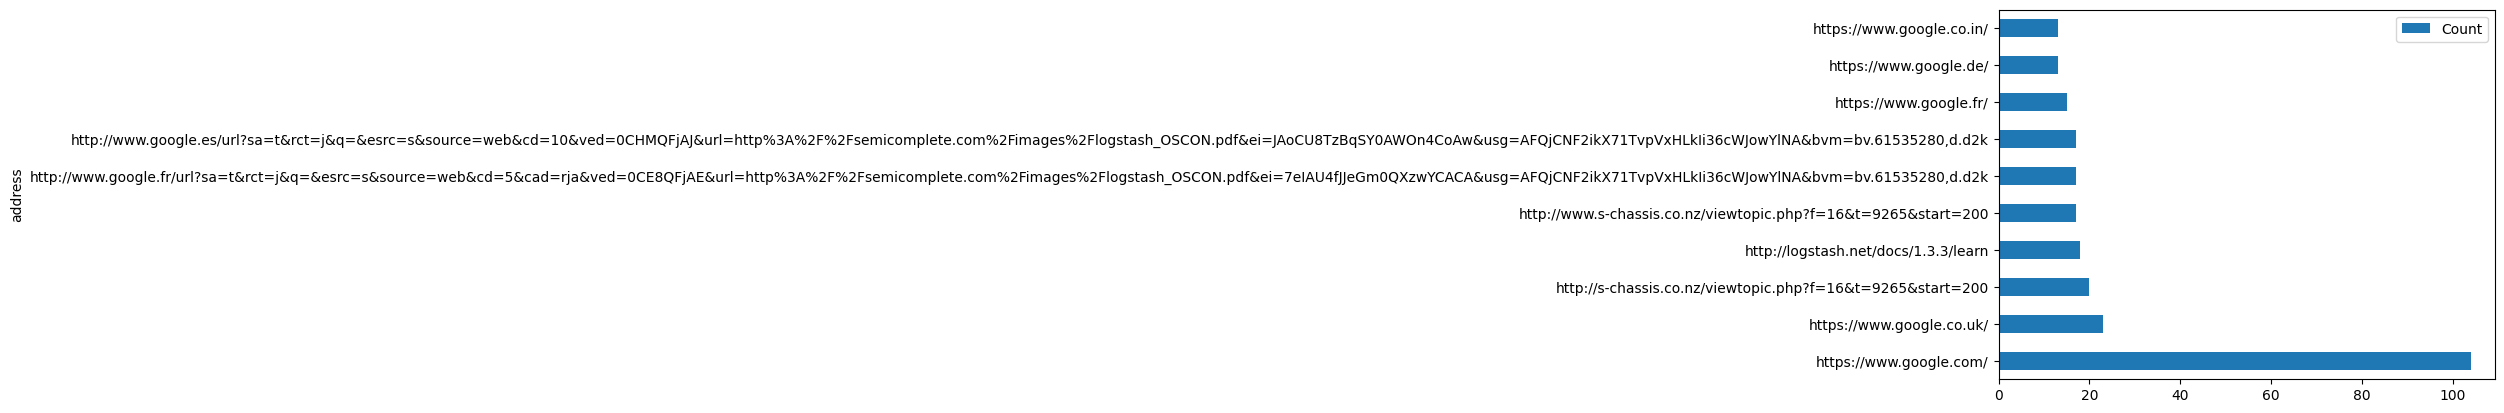

In [145]:
dfReferer.plot.barh(x = 'address')

### Task 2

Narysować wykres rankingu pobieranych plików graficznych

In [147]:
regex_images = r'"GET (.+\.png) .+?"'

In [149]:
images_test = re.search(regex_images, 'fdsfsf "GET /images/jordan-80.png HTTP/1.1" btret -09ghf - gfdg').group(1)

print(images_test)

/images/jordan-80.png


In [150]:
images = lines.map(lambda s: (re.search(regex_images, s).group(1) if re.search(regex_images, s) else "Image file not found", 1))

In [151]:
imagesCount = images.reduceByKey(lambda a, b: a + b)

In [152]:
imagesCount.collect()

[('/presentations/logstash-monitorama-2013/images/kibana-search.png', 6),
 ('/presentations/logstash-monitorama-2013/images/kibana-dashboard3.png', 8),
 ('/presentations/logstash-monitorama-2013/images/frontend-response-codes.png',
  5),
 ('/presentations/logstash-monitorama-2013/images/redis.png', 5),
 ('/presentations/logstash-monitorama-2013/images/elasticsearch.png', 4),
 ('/images/jordan-80.png', 533),
 ('/images/googledotcom.png', 101),
 ('/images/proofsocietyisdoomed.png', 1),
 ('/presentations/logstash-puppetconf-2012/images/nagios-sms1.png', 26),
 ('/presentations/logstash-puppetconf-2012/images/nagios-sms4.png', 22),
 ('/presentations/logstash-puppetconf-2012/images/nagios-sms2.png', 23),
 ('/presentations/logstash-puppetconf-2012/images/xkcd-perl.png', 24),
 ('/presentations/logstash-puppetconf-2012/images/kibana-chef-agent.png', 23),
 ('/presentations/logstash-puppetconf-2012/images/kibana-logstash-downloads.png',
  33),
 ('/presentations/logstash-puppetconf-2012/images/sta

In [156]:
topImages = imagesCount.takeOrdered(11, lambda pair: -pair[1])
topImages

[('Image file not found', 7669),
 ('/images/jordan-80.png', 533),
 ('/images/web/2009/banner.png', 516),
 ('/presentations/logstash-scale11x/images/ahhh___rage_face_by_samusmmx-d5g5zap.png',
  128),
 ('/images/googledotcom.png', 101),
 ('/presentations/logstash-puppetconf-2012/images/kibana-logstash-downloads.png',
  33),
 ('/presentations/logstash-scale11x/images/logstash.png', 33),
 ('/presentations/logstash-puppetconf-2012/images/nagios-sms1.png', 26),
 ('/presentations/logstash-puppetconf-2012/images/apache-negative-duration.png',
  25),
 ('/presentations/logstash-puppetconf-2012/images/xkcd-perl.png', 24),
 ('/presentations/logstash-puppetconf-2012/images/sysadvent.png', 24)]

In [157]:
df_images = pd.DataFrame(topImages, columns = ['image', 'count'])
df_images = df_images[df_images['image'] != 'Image file not found']
df_images

,image,count
1,/images/jordan-80.png,533
2,/images/web/2009/banner.png,516
3,/presentations/logstash-scale11x/images/ahhh__...,128
4,/images/googledotcom.png,101
5,/presentations/logstash-puppetconf-2012/images...,33
6,/presentations/logstash-scale11x/images/logsta...,33
7,/presentations/logstash-puppetconf-2012/images...,26
8,/presentations/logstash-puppetconf-2012/images...,25
9,/presentations/logstash-puppetconf-2012/images...,24
10,/presentations/logstash-puppetconf-2012/images...,24


<Axes: ylabel='image'>

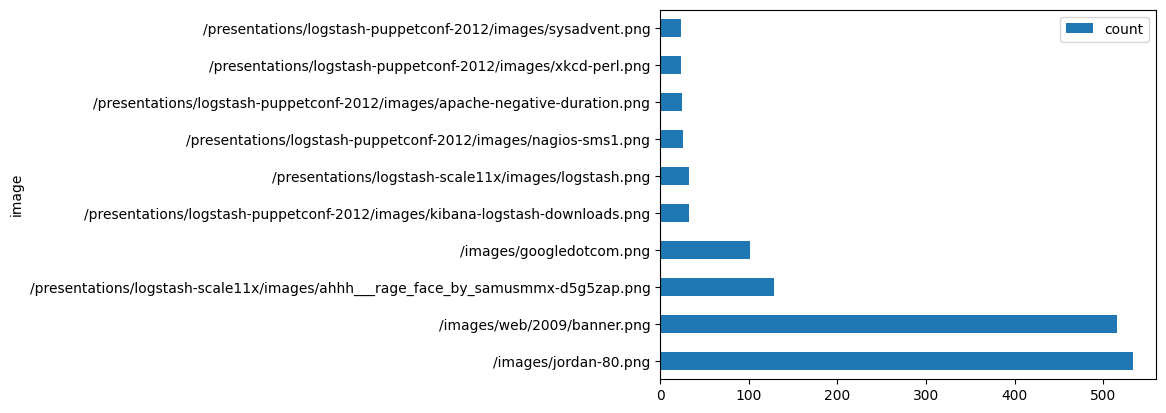

In [158]:
df_images.plot.barh(x = 'image')

### Task 3

Narysować średni dobowy wykres liczby wywołań (request) na minutę w zależności od czasu.

In [169]:
regex_datetime = r'\[(?P<date>\d{1,2}/[a-zA-Z]+/\d{4}):(?P<time_minute_precision>\d{2}:\d{2}):\d{2} .+?\]'

datetime_test = re.search(regex_datetime, 'fdsfsf [17/May/2015:10:05:03 +0000] - gfdg').group('time_minute_precision')

print(datetime_test)

10:05


In [170]:
# klucz (data, godzina)
datetimes = lines.map(lambda s: ((re.search(regex_datetime, s).group('date'), re.search(regex_datetime, s).group('time_minute_precision')) if re.search(regex_datetime, s) else "Date not found", 1))

In [171]:
datetimeCount = datetimes.reduceByKey(lambda a, b: a + b)

In [174]:
num_of_query_calls = datetimeCount.sortBy(lambda pair: pair[0]).collect()
num_of_query_calls

[(('17/May/2015', '10:05'), 74),
 (('17/May/2015', '11:05'), 111),
 (('17/May/2015', '12:05'), 115),
 (('17/May/2015', '13:05'), 118),
 (('17/May/2015', '14:05'), 120),
 (('17/May/2015', '15:05'), 125),
 (('17/May/2015', '16:05'), 126),
 (('17/May/2015', '17:05'), 123),
 (('17/May/2015', '18:05'), 118),
 (('17/May/2015', '19:05'), 121),
 (('17/May/2015', '20:05'), 129),
 (('17/May/2015', '21:05'), 123),
 (('17/May/2015', '22:05'), 118),
 (('17/May/2015', '23:05'), 111),
 (('18/May/2015', '00:05'), 116),
 (('18/May/2015', '01:05'), 118),
 (('18/May/2015', '02:05'), 125),
 (('18/May/2015', '03:05'), 114),
 (('18/May/2015', '04:05'), 115),
 (('18/May/2015', '05:05'), 125),
 (('18/May/2015', '06:05'), 121),
 (('18/May/2015', '07:05'), 124),
 (('18/May/2015', '08:05'), 110),
 (('18/May/2015', '09:05'), 122),
 (('18/May/2015', '10:05'), 132),
 (('18/May/2015', '11:05'), 121),
 (('18/May/2015', '12:05'), 120),
 (('18/May/2015', '13:05'), 119),
 (('18/May/2015', '14:05'), 122),
 (('18/May/2015

In [178]:
dfQueryCallsPerMinute = pd.DataFrame(num_of_query_calls, columns = ['datetime', 'count'])
dfQueryCallsPerMinute

,datetime,count
0,"(17/May/2015, 10:05)",74
1,"(17/May/2015, 11:05)",111
2,"(17/May/2015, 12:05)",115
3,"(17/May/2015, 13:05)",118
4,"(17/May/2015, 14:05)",120
...,...,...
79,"(20/May/2015, 17:05)",119
80,"(20/May/2015, 18:05)",107
81,"(20/May/2015, 19:05)",123
82,"(20/May/2015, 20:05)",120


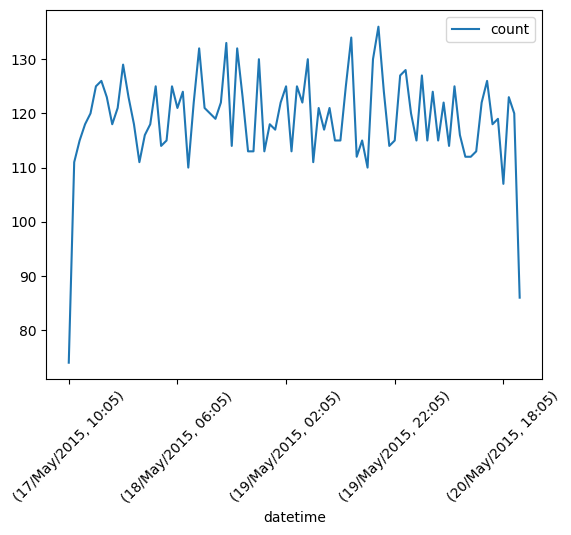

In [180]:
dfQueryCallsPerMinute.plot(x = 'datetime', y = 'count')
plt.xticks(rotation=45)
plt.show()

In [196]:
# Jak wyglądała aktywność w konkretnej godzinie i minucie ( np. 10:05) na przestrzeni wszystkich ddni

# klucz -> godzina
datetimes2 = lines.map(lambda s: (re.search(regex_datetime, s).group('time_minute_precision') if re.search(regex_datetime, s) else "Date not found", 1))

datetimeCount2 = datetimes2.reduceByKey(lambda a, b: a + b)

datetimeCount2.take(5)

[('11:05', 459),
 ('12:05', 462),
 ('14:05', 498),
 ('17:05', 484),
 ('21:05', 453)]

In [202]:
num_of_days = 4

# x[0] pierwszy element krotki pozostaje bez zmian, drugi element (liczba wywołań) jest sumowany
average_by_minute =  datetimeCount2.map(lambda x: (x[0], x[1] / num_of_days))

average = average_by_minute.sortBy(lambda pair: pair[0]).collect()
average

[('00:05', 90.25),
 ('01:05', 90.0),
 ('02:05', 91.25),
 ('03:05', 88.5),
 ('04:05', 88.75),
 ('05:05', 92.75),
 ('06:05', 91.5),
 ('07:05', 89.25),
 ('08:05', 86.25),
 ('09:05', 91.0),
 ('10:05', 110.75),
 ('11:05', 114.75),
 ('12:05', 115.5),
 ('13:05', 118.75),
 ('14:05', 124.5),
 ('15:05', 124.0),
 ('16:05', 118.25),
 ('17:05', 121.0),
 ('18:05', 119.5),
 ('19:05', 123.25),
 ('20:05', 121.5),
 ('21:05', 113.25),
 ('22:05', 86.5),
 ('23:05', 89.0)]

In [203]:
dfAverageCalls = pd.DataFrame(average, columns = ['time', 'average'])
dfAverageCalls

,time,average
0,00:05,90.25
1,01:05,90.00
2,02:05,91.25
3,03:05,88.50
4,04:05,88.75
5,05:05,92.75
6,06:05,91.50
7,07:05,89.25
8,08:05,86.25
9,09:05,91.00


<Axes: xlabel='time'>

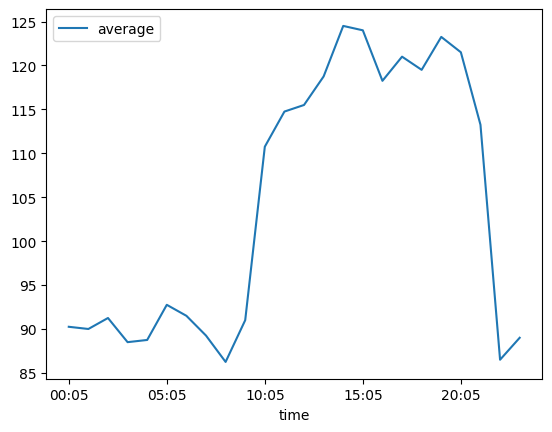

In [204]:
dfAverageCalls.plot(x = 'time', y = 'average')

### Task 4

Narysować wykres (pie chart) popularności systemów operacyjnych klienta

In [264]:
regex_os = r'\([^;]+; (?P<os>[^;]+?)(;|\))'

os_test = re.finditer(regex_os, 'reewrfg "Mozilla/5.0 (X11; Linux x86_64; rv:25.0) Gecko/20100101 Firefox/25.0" rtege -- "Tiny Tiny RSS/1.11 (http://tt-rss.org/)"  gygj   "Mozilla/5.0 (iPhone; CPU iPhone OS 6_0 like Mac OS X)" ')

for m in os_test:
  print(m.group('os'))

Linux x86_64
CPU iPhone OS 6_0 like Mac OS X


In [270]:
op_sys = lines.map(lambda s: (re.search(regex_os, s).group('os') if re.search(regex_os, s) else "Operating system not found", 1))

opSysCount = op_sys.reduceByKey(lambda a, b: a + b)

osFavourite = opSysCount.takeOrdered(11, lambda pair: -pair[1])
osFavourite

[('WOW64', 2068),
 ('Operating system not found', 1476),
 ('Linux x86_64', 1218),
 ('Intel Mac OS X 10_9_1', 692),
 ('Ubuntu', 512),
 ('Intel Mac OS X 10.7', 301),
 ('U', 280),
 ('CPU iPhone OS 6_0 like Mac OS X', 274),
 ('Linux i686', 252),
 ('Googlebot/2.1', 239),
 ('MSIE 9.0', 200)]

In [288]:
dfOs = pd.DataFrame(osFavourite, columns = ['os', 'count'])
dfOs = dfOs[dfOs['os'] != 'Operating system not found']
dfOs

,os,count
0,WOW64,2068
2,Linux x86_64,1218
3,Intel Mac OS X 10_9_1,692
4,Ubuntu,512
5,Intel Mac OS X 10.7,301
6,U,280
7,CPU iPhone OS 6_0 like Mac OS X,274
8,Linux i686,252
9,Googlebot/2.1,239
10,MSIE 9.0,200


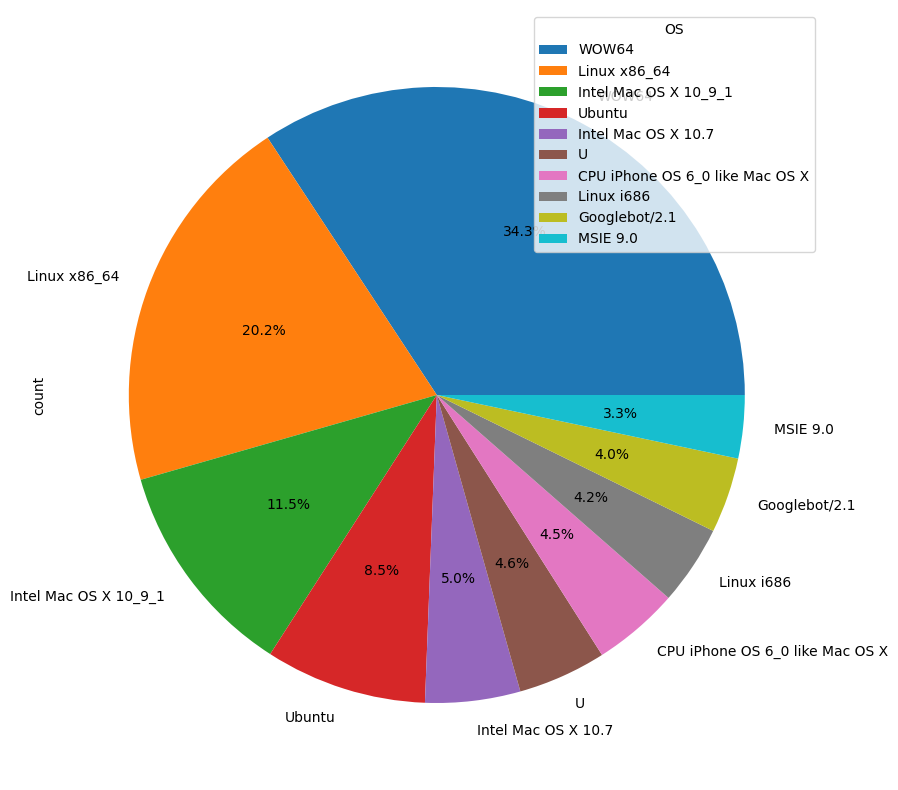

In [289]:
dfOs.set_index('os', inplace=True)


dfOs.plot.pie(y = 'count',  autopct='%1.1f%%', figsize = (10, 10))
plt.legend(title="OS", labels=dfOs.index)

### Task 6

Narysować mapę z lokalizacjami klientów

In [291]:
ipAddresses = ipCounts.sortBy(lambda pair: -pair[1]).collect()

In [292]:
df_ip_address = pd.DataFrame(ipAddresses, columns = ['ip', 'count'])
df_ip_address

,ip,count
0,66.249.73.135,482
1,46.105.14.53,364
2,130.237.218.86,357
3,75.97.9.59,273
4,50.16.19.13,113
...,...,...
1748,46.166.199.137,1
1749,80.94.240.100,1
1750,188.252.129.118,1
1751,120.136.4.243,1


In [302]:
pip install geocoder folium ipinfo

In [303]:
#import geocoder
import folium
import ipinfo

In [309]:
access_token = '97c3e4ae230cef'
handler = ipinfo.getHandler(access_token)

def get_location(ip):
  g = handler.getDetails(ip)
  if g:
    lat, lon = map(float, g.loc.split(','))
    return pd.Series([lat, lon, g.country, g.city],
                     index = ['lat', 'lng', 'country', 'city'])
  else:
    return pd.Series([None, None, None, None],
                     index = ['lat', 'lng', 'country', 'city'])

df_ip_address[['lat', 'lon', 'country', 'city']] = df_ip_address['ip'].apply(get_location)
df_ip_address

,ip,count,latitude,lat,lon,country,city
0,66.249.73.135,482,"[35.4676, -97.5164]",35.4676,-97.5164,US,Oklahoma City
1,46.105.14.53,364,"[48.5839, 7.7455]",48.5839,7.7455,FR,Strasbourg
2,130.237.218.86,357,"[59.3294, 18.0687]",59.3294,18.0687,SE,Stockholm
3,75.97.9.59,273,"[40.1798, -76.1788]",40.1798,-76.1788,US,Ephrata
4,50.16.19.13,113,"[39.0437, -77.4875]",39.0437,-77.4875,US,Ashburn
...,...,...,...,...,...,...,...
1748,46.166.199.137,1,None,56.5003,84.9820,RU,Tomsk
1749,80.94.240.100,1,None,46.8427,29.6291,MD,Tiraspol
1750,188.252.129.118,1,None,45.8144,15.9780,HR,Zagreb
1751,120.136.4.243,1,None,-36.8485,174.7635,NZ,Auckland


In [318]:
map = folium.Map(location=[20, 0], zoom_start=2, width=1400, height=1100)

for index, row in df_ip_address.iterrows():
  if pd.notnull(row['lat'] and pd.notnull(row['lon'])):
    folium.Marker(location=[row['lat'], row['lon']],
                  popup=f"{row['city']}, {row['country']}",
                  icon=folium.Icon(color="pink")).add_to(map)

map

### Task 5

Oszacować jaki procent ruchu generują boty. Porównać co najmniej 2 sposoby oszacowania.

##### Sposób 1: regex

In [327]:
# ostatnie wystąpienie czegoś w cudzysłowie, co zawiera podciąg "bot"
regex_user_agent = r'"([^"]*bot[^"]*)"'

test_user_agent = re.findall(regex_user_agent, '83.149.9.216 - - [17/May/2015:10:05:43 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-dashboard3.png HTTP/1.1" 200 171717 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)bot AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"')

test_user_agent[-1]

'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)bot AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36'

In [328]:
bots = lines.map(lambda s: (re.findall(regex_user_agent, s)[-1] if re.findall(regex_user_agent, s) else "Not bot", 1))

botsCount = bots.reduceByKey(lambda a, b: a + b)

botsCount.sortBy(lambda pair: -pair[1]).collect()

[('Not bot', 8689),
 ('Mozilla/5.0 (iPhone; CPU iPhone OS 6_0 like Mac OS X) AppleWebKit/536.26 (KHTML, like Gecko) Version/6.0 Mobile/10A5376e Safari/8536.25 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)',
  271),
 ('Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)',
  237),
 ('Mozilla/5.0 (compatible; archive.org_bot +http://www.archive.org/details/archive.org_bot)',
  166),
 ('msnbot/2.0b (+http://search.msn.com/msnbot.htm)', 96),
 ('GET /robots.txt HTTP/1.1', 94),
 ('Mozilla/5.0 (compatible; YandexBot/3.0; +http://yandex.com/bots)', 64),
 ('Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm)',
  58),
 ('Mozilla/5.0 (compatible; MJ12bot/v1.4.4; http://www.majestic12.co.uk/bot.php?+)',
  39),
 ('Mozilla/5.0 (compatible; AhrefsBot/5.0; +http://ahrefs.com/robot/)', 34),
 ('Twitterbot/1.0', 28),
 ('Mozilla/5.0 (compatible; Exabot/3.0 (BiggerBetter); +http://www.exabot.com/go/robot)',
  22),
 ('msnbot-media/1.1 (+http://search.ms

In [336]:
# oznaczenie wszystkich linii za pomocą regex
botLines = lines.map(lambda s: (1 if re.findall(regex_user_agent, s) else 0))

botCount = botLines.reduce(lambda a, b: a + b)

print(botCount)

linesCount = lines.count()
print(linesCount)

print(botCount + 8689 == linesCount)


1311
10000
True


In [339]:
print(f"Procent ruchu generowanego przez boty: {botCount / linesCount:.2f}%")

Procent ruchu generowanego przez boty: 0.13%


#### Sposób 2: biblioteka user-agents

In [340]:
pip install pyyaml ua-parser user-agents


In [341]:
from user_agents import parse

def check_if_bot(l):
  user_agent = parse(l)
  if user_agent.is_bot:
    return 1
  else:
    return 0

In [344]:
user_agents = lines.map(check_if_bot)

botsCount2 = user_agents.reduce(lambda a, b: a + b)

print(botsCount2)

1089


In [345]:
print(f"Procent ruchu generowanego przez boty: {botsCount2 / linesCount:.2f}%")

Procent ruchu generowanego przez boty: 0.11%
